## DQN Training
This is the first experiment using the CartPole environment. The experiments in CartPole act as a tutorial on how to use our code and all the other experiments are based upon them, so this provides a good starting point if you want to run your own experiments. 
The tutorials build upon each other and it is recommended to follow them in the following order:
1. DQN-Training (How to train a conventional DQN and a spiking DQN using Surrogate Gradients (DSQN).)
2. Load-DQN (How to load a previously saved D(S)QN and how to save a replay dataset.)
3. Train-Classifier (How to train a spiking or non-spiking classifier on the saved replay data set.)
4. SNN-Conversion (How to convert a DQN and a Classifier to a SNN.)
5. Load in NEST (How to load a converted or directly trained spiking network in NEST.)
6. Conversion in pyNN with NEST or SpyNNaker (How to load spiking network in pyNN using NEST or SpyNNaker as backend.)

In this first part we train a DQN (non-spiking and spiking) on the CartPole problem. At the same time this file serves as a tutorial for training DQNs with any environment.

In [1]:
import os
import sys
import random

import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# hack to perform relative imports
sys.path.append('../../')
from datetime import date
from Code import train_agent, SQN, FullyConnected

We start with setting up the result directory.
<div class="alert alert-block alert-warning">
<b>Attention:</b> If the directory with the specified name already exists, this will throw an error. You need to specify a different name or delete the old directory. If this happens, you should restart the kernel, as the directory is a relative path which changes everytime this cell is run.
</div>

In [2]:
# Create Results Directory
dirs = os.listdir('.')
if not any('result' in d and 'DQN' in d for d in dirs):
    result_id = 1
else:
    results = [d for d in dirs if 'result' in d and 'DQN' in d]
    result_id = len(results) + 1

# Get today's date and add it to the results directory
d = date.today()
result_dir = 'result_' + str(result_id) + '_DQN_{}'.format(str(d.year) + str(d.month) + str(d.day))
os.mkdir(result_dir)
print('Created Directory {} to store the results in'.format(result_dir))

Created Directory result_1_DQN_20201118 to store the results in


We define the seeds, hyperparameters and initial weights to values that reached the Open AI gym standard succesfully. This should make the results reproducible if you install the virtual environment specified in requirements.txt

Next, we define the environment and all the hyperparameters for a non-spiking Q-network. We then set up the result directory. 

In [3]:
# CartPole
env = 'CartPole-v0'

# hyperparameters
batch_size = 128
discount_factor = 0.999
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.999
target_update_frequency = 10
learning_rate = 0.001
replay_memory_size = 4*10**4

# minimum size of the replay memory before the training starts
initial_replay_size = 0

# the gym standard for CartPole ("solving" it) is to achieve a 100-episode average of <=195 for 100 consecutive episodes
GYM_TARGET_AVG = 195
GYM_TARGET_DURATION = 100

max_steps = 1000
num_episodes = 1000
n_runs = 5

double_q = False
gradient_clipping = False
render = False

architecture = [4, 16, 16, 2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next we initialize the neural network for the problem: We use a Fully-Connected network with two hidden layers with 16 neurons each and ReLu activations. The size of the in- and output layers is determined by the environment. 
The target net initially is a copy of the policy net.
Then we set up the optimizer: We use Adam using the specified learning and rate and the standard parameters for everything else.
The seed fixes the inital weight. Instad, we could also save the initial weights of a network (commented lines below definition of policy net.

We now train the agent with the specified hyperparameters using the function from Code/train_agent. In the plot, blue shows the individual reward on each episode, while orange shows the average reward over the last 100 episodes.

In [4]:
torch_seeds = [random.randint(0, 1000) for _ in range(n_runs)]
random_seeds = [random.randint(0, 1000) for _ in range(n_runs)]
gym_seeds = [random.randint(0, 1000) for _ in range(n_runs)]

In [5]:
smoothed_scores_dqn_all = []

for i_run in range(n_runs):
    torch_seed = torch_seeds[i_run]
    random_seed = random_seeds[i_run]
    gym_seed = gym_seeds[i_run]
    
    torch.manual_seed(torch_seed)
    random.seed(random_seed)
    
    policy_net = FullyConnected(architecture).to(device)
    target_net = FullyConnected(architecture).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    scores, smoothed_scores = train_agent(env, policy_net, target_net, batch_size,
                                          discount_factor, epsilon_start, epsilon_end,
                                          epsilon_decay, target_update_frequency, optimizer,
                                          learning_rate, replay_memory_size, device, i_run,
                                          result_dir, num_episodes=num_episodes,
                                          max_steps=max_steps, render=render,
                                          double_q_learning=double_q,
                                          gradient_clipping=gradient_clipping,
                                          initial_replay_size=initial_replay_size,
                                          gym_seed=gym_seed, torch_seed=torch_seed,
                                          random_seed=random_seed)
    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_{}'.format(i_run), smoothed_scores)
    
    # save smoothed scores in list to plot later
    smoothed_scores_dqn_all.append(smoothed_scores)

/home/akl-ma/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 114.09	 Epsilon: 0.05
Episode 200	Average Score: 237.67	 Epsilon: 0.05
Episode 300	Average Score: 132.69	 Epsilon: 0.05
Episode 400	Average Score: 100.54	 Epsilon: 0.05
Episode 500	Average Score: 116.93	 Epsilon: 0.05
Episode 600	Average Score: 273.28	 Epsilon: 0.05
Episode 700	Average Score: 202.44	 Epsilon: 0.05
Episode 800	Average Score: 535.40	 Epsilon: 0.05
Episode 900	Average Score: 136.94	 Epsilon: 0.05
Episode 1000	Average Score: 567.51	 Epsilon: 0.05
Best 100 episode average:  567.51  reached at episode  1000 . Model saved in folder best.
Complete


<Figure size 432x288 with 0 Axes>

Episode 100	Average Score: 51.54	 Epsilon: 0.05
Episode 200	Average Score: 147.81	 Epsilon: 0.05
Episode 300	Average Score: 132.49	 Epsilon: 0.05
Episode 400	Average Score: 135.11	 Epsilon: 0.05
Episode 500	Average Score: 122.99	 Epsilon: 0.05
Episode 600	Average Score: 111.79	 Epsilon: 0.05
Episode 700	Average Score: 124.10	 Epsilon: 0.05
Episode 800	Average Score: 129.49	 Epsilon: 0.05
Episode 900	Average Score: 134.72	 Epsilon: 0.05
Episode 1000	Average Score: 134.75	 Epsilon: 0.05
Best 100 episode average:  149.87  reached at episode  190 . Model saved in folder best.
Complete


<Figure size 432x288 with 0 Axes>

Episode 100	Average Score: 49.59	 Epsilon: 0.05
Episode 200	Average Score: 201.60	 Epsilon: 0.05
Episode 300	Average Score: 194.40	 Epsilon: 0.05
Episode 400	Average Score: 158.05	 Epsilon: 0.05
Episode 500	Average Score: 129.49	 Epsilon: 0.05
Episode 600	Average Score: 138.85	 Epsilon: 0.05
Episode 700	Average Score: 145.63	 Epsilon: 0.05
Episode 800	Average Score: 713.61	 Epsilon: 0.05
Episode 900	Average Score: 656.80	 Epsilon: 0.05
Episode 1000	Average Score: 81.80	 Epsilon: 0.05
Best 100 episode average:  946.27  reached at episode  831 . Model saved in folder best.
Complete


<Figure size 432x288 with 0 Axes>

Episode 100	Average Score: 54.79	 Epsilon: 0.05
Episode 200	Average Score: 170.62	 Epsilon: 0.05
Episode 300	Average Score: 399.77	 Epsilon: 0.05
Episode 400	Average Score: 191.32	 Epsilon: 0.05
Episode 500	Average Score: 201.68	 Epsilon: 0.05
Episode 600	Average Score: 395.54	 Epsilon: 0.05
Episode 700	Average Score: 231.23	 Epsilon: 0.05
Episode 800	Average Score: 212.25	 Epsilon: 0.05
Episode 900	Average Score: 593.31	 Epsilon: 0.05
Episode 1000	Average Score: 805.29	 Epsilon: 0.05
Best 100 episode average:  941.26  reached at episode  982 . Model saved in folder best.
Complete


<Figure size 432x288 with 0 Axes>

Episode 100	Average Score: 43.12	 Epsilon: 0.05
Episode 200	Average Score: 149.99	 Epsilon: 0.05
Episode 300	Average Score: 117.05	 Epsilon: 0.05
Episode 400	Average Score: 154.43	 Epsilon: 0.05
Episode 500	Average Score: 153.94	 Epsilon: 0.05
Episode 600	Average Score: 146.79	 Epsilon: 0.05
Episode 700	Average Score: 159.80	 Epsilon: 0.05
Episode 800	Average Score: 943.58	 Epsilon: 0.05
Episode 900	Average Score: 842.50	 Epsilon: 0.05
Episode 1000	Average Score: 623.93	 Epsilon: 0.05
Best 100 episode average:  946.19  reached at episode  807 . Model saved in folder best.
Complete


<Figure size 432x288 with 0 Axes>

The figure above shows the training progress of the model. Once the Open AI gym standard is reached, the model is saved
in the result directory as trained/model.pt. Additionally, before the training starts the initial weights and the hyperparameters are saved.

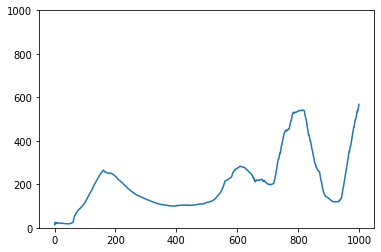

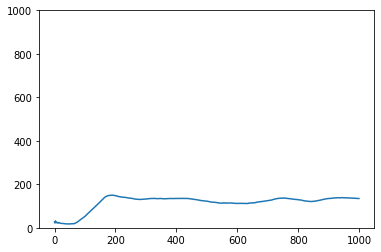

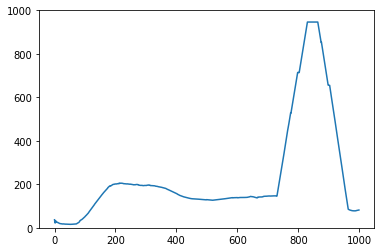

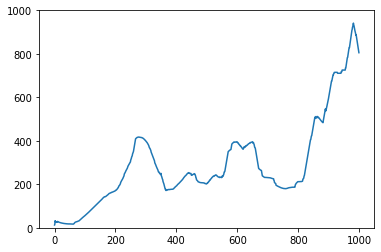

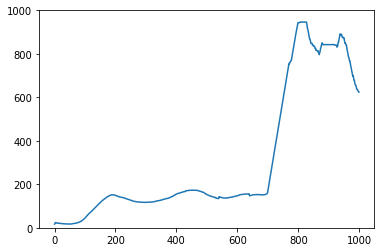

In [6]:
# Plot scores of individual runs
for i in range(len(smoothed_scores_dqn_all)):
    fig = plt.figure()
    plt.plot(smoothed_scores_dqn_all[i])
    plt.ylim(0, 1000)
    plt.savefig(result_dir + '/training_{}.png'.format(i), dpi=1000)
    plt.show()

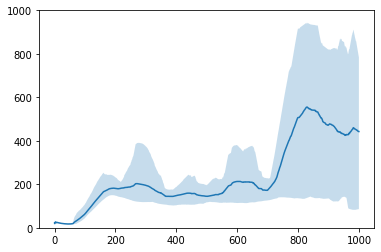

In [10]:
# Plot results (mean)
mean_smoothed_scores = np.mean(smoothed_scores_dqn_all, axis=0)
fig = plt.figure()
plt.plot(range(len(smoothed_scores_dqn_all[0])), mean_smoothed_scores)
plt.fill_between(range(len(smoothed_scores_dqn_all[0])),
                 np.nanpercentile(smoothed_scores_dqn_all, 2, axis=0),
                 np.nanpercentile(smoothed_scores_dqn_all, 97, axis=0), alpha=0.25)
plt.ylim(0, 1000)
plt.savefig(result_dir + '/DQN_training.png', dpi=1000)
plt.show()


### Training of a spiking DQN or DSQN
Next, we train a DSQN using the same hyperparameters as far as possible. That is, all hyperparameters are the same, but we need to define some additional hyperparameters. We adapted the surrogate gradient algorithm we use for the direct training from the SpyTorch jupyter notebooks (available from https://github.com/fzenke/spytorch as of 06.12.2019).

In [11]:
dirs = os.listdir('.')
if not ('result' in d and 'DSQN' in d for d in dirs):
    result_id = 1
else:
    results = [d for d in dirs if 'result' in d and 'DSQN' in d]
    result_id = len(results) + 1

# Get today's date and add it to the results directory
d = date.today()
result_dir = 'result_' + str(result_id) + '_DSQN_{}'.format(str(d.year) + str(d.month) + str(d.day))
os.mkdir(result_dir)
print('Created Directory {} to store the results in'.format(result_dir))

Created Directory result_1_DSQN_20201118 to store the results in


In [12]:
# We use a non-leaky integrate-and-fire neuron
ALPHA = 0
BETA = 1

# Simulation time is chosen relatively short, such that the network does not need too much
# time to run, but not too short, such that it can still learn something
SIMULATION_TIME = 20

# We also have to define the input/output and reset methods, to our knowledge, SpyTorch
# supports only potential outputs  and reset-by-subtraction. As input method we use constant
# input currents. It would be interesting to see if SpyTorch can also use reset-to-zero, as
# this would make it more similar to the iaf_delta models in NEST and SpyNNaker
ENCODING = 'constant'
DECODING = 'potential'
RESET = 'subtraction'

# SpyTorch uses a fixed threshold of one, we didn't test other thresholds, but should
# be possible
THRESHOLD = 1

architecture = [4, 17, 17, 2]


Now, we set up the neural network. Note, that SpyTorch does not support biases, so we instead add a constant input to each observation (equivalent to first layer biases) and add one additional neuron to each hidden layer to compensate for the missing biases.

In the next cell, the agent is trained. The function we use, is exactly the same as for the DQN, the only difference is that the model we pass now is an instance of our SQN class, rather than the PyTorch neural network base class.

In [ ]:
smoothed_scores_dsqn_all = []
for i_run in range(n_runs):
    torch_seed = torch_seeds[i_run]
    random_seed = random_seeds[i_run]
    gym_seed = gym_seeds[i_run]
    
    torch.manual_seed(torch_seed)
    random.seed(random_seed)

    policy_net = SQN(architecture, device, alpha=ALPHA, beta=BETA,
                 simulation_time=SIMULATION_TIME, add_bias_as_observation=True,
                 encoding=ENCODING, decoding=DECODING, reset=RESET, threshold=THRESHOLD)
    target_net = SQN(architecture, device, alpha=0, beta=1, simulation_time=SIMULATION_TIME,
                 add_bias_as_observation=True, encoding=ENCODING, decoding=DECODING,
                 reset=RESET, threshold=THRESHOLD)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    scores, smoothed_scores = train_agent(env, policy_net, target_net, batch_size,
                                          discount_factor, epsilon_start, epsilon_end,
                                          epsilon_decay, target_update_frequency, optimizer,
                                          learning_rate, replay_memory_size, device, i_run,
                                          result_dir, num_episodes=num_episodes,
                                          max_steps=max_steps, render=render,
                                          double_q_learning=double_q,
                                          gradient_clipping=gradient_clipping,
                                          initial_replay_size=initial_replay_size,
                                          gym_seed=gym_seed, torch_seed=torch_seed,
                                          random_seed=random_seed)
    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_{}'.format(i_run), smoothed_scores)

    # save smoothed scores in list to plot later
    smoothed_scores_dsqn_all.append(smoothed_scores)

/home/akl-ma/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 168.31	 Epsilon: 0.05
Episode 200	Average Score: 96.14	 Epsilon: 0.055


The plot again shows the rewards in each episode (blue) and the average reward over the last 100 episodes (orange).

The next experiment in this series is Load-DQN.

In [ ]:
mean_smoothed_scores = np.mean(smoothed_scores_dsqn_all, axis=0)
fig = plt.figure()
plt.plot(range(len(smoothed_scores_dsqn_all[0])), mean_smoothed_scores)
plt.fill_between(range(len(smoothed_scores_dsqn_all[0])),
                 np.nanpercentile(smoothed_scores_dsqn_all, 2, axis=0),
                 np.nanpercentile(smoothed_scores_dsqn_all, 97, axis=0), alpha=0.25)
plt.ylim(0, 1000)
plt.savefig(result_dir + '/DQN_training.png', dpi=1000)
plt.show()

In [ ]:
mean_smoothed_scores_dqn = np.mean(smoothed_scores_dqn_all, axis=0)
mean_smoothed_scores_dsqn = np.mean(smoothed_scores_dqn_all, axis=0)

fig = plt.figure()

plt.plot(range(len(smoothed_scores_dqn_all[0])), mean_smoothed_scores, color='b')
plt.fill_between(range(len(smoothed_scores_dqn_all[0])),
                 np.nanpercentile(smoothed_scores_dqn_all, 2, axis=0),
                 np.nanpercentile(smoothed_scores_dqn_all, 97, axis=0), alpha=0.25)

plt.plot(range(len(smoothed_scores_dsqn_all[0])), mean_smoothed_scores, color='r')
plt.fill_between(range(len(smoothed_scores_dsqn_all[0])),
                 np.nanpercentile(smoothed_scores_dsqn_all, 2, axis=0),
                 np.nanpercentile(smoothed_scores_dsqn_all, 97, axis=0), alpha=0.25)

plt.ylim(0, 1000)
plt.savefig(result_dir + '/DQN_vs_DSQN_training.png', dpi=1000)
plt.show()